<h1> Movie Recommender </h1>
<p> In this notebook, I'll be creating a baseline for a movie recommender system using the <a href="https://www.kaggle.com/tmdb/tmdb-movie-metadata/downloads/tmdb-5000-movie-dataset.zip/2"> TMDB Dataset. </a> </p>

In [3]:
import pandas as pd
import numpy as np
import io
import requests
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from ast import literal_eval
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
path = "C:\\Users\\alexander.leite\\Downloads\\tmdb-5000-movie-dataset"

In [5]:
df_Credits = pd.read_csv(path + "\\" + "tmdb_5000_credits.csv")
df_Movies = pd.read_csv(path + "\\" + "tmdb_5000_movies.csv")

In [ ]:
df_Credits.head()

In [ ]:
df_Movies.head()

In [6]:
df_Credits.columns = ['id','tittle','cast','crew']

In [7]:
df_Movies = df_Movies.merge(df_Credits,on='id')
df_Movies.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


<h2> Creating a demographic filtering </h2>
<p> Demografic filters offers a generalized recommendation to every user, <p/>
<p> 1. We need a metric to score or rate movie. </p>
<p> 2. Calculate the score for every movie. </p>
<p> 3. Sort the scores and recommend the best rated movie to the users.  </p>
<p> In this notebook, I'll use the TMDB formula to calculate the movie rating, wich is weighted rating(WR). <p/>
<img src="https://image.ibb.co/jYWZp9/wr.png">
<p> v is the number of votes for the movie <p/>
m is the minimum votes required to be listed in the chart <p/>
R is the average rating of the movie </p>
C is the mean vote across the whole report 

In [8]:
C = df_Movies['vote_average'].mean()
C

6.092171559442011

In [9]:
m = df_Movies['vote_count'].quantile(0.9)
m

1838.4000000000015

In [10]:
m_movies = df_Movies.copy().loc[df_Movies['vote_count'] >= m]
m_movies.shape

(481, 23)

In [11]:
def Weighted_Rating(x,m=m,C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m)*R) + (m/(v+m)*C)

In [12]:
m_movies['scores'] = df_Movies.apply(Weighted_Rating,axis=1)

In [13]:
#Sort movies based on score calculated above
m_movies = m_movies.sort_values('scores', ascending=False)

#Print the top 15 movies
m_movies[['title', 'vote_count', 'vote_average', 'scores']].head(10)

,title,vote_count,vote_average,scores
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


Text(0.5,1,'Popular Movies')

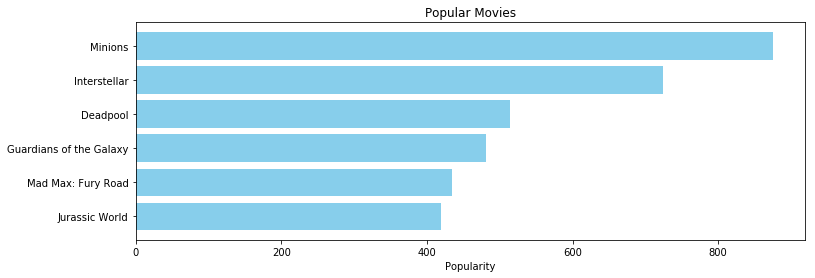

In [14]:
pop= m_movies.sort_values('popularity', ascending=False)
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

<h2> Content Based Filtering </h2>

In [30]:
df_Movies['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

In [15]:
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df_Movies['overview'] = df_Movies['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df_Movies['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4803, 20978)

In [16]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [17]:
df_Movies.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            4793, 4794, 4795, 4796, 4797, 4798, 4799, 4800, 4801, 4802],
           dtype='int64', length=4803)

In [18]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df_Movies.index, index=df_Movies['title']).drop_duplicates()

In [16]:
cosine_sim.shape

(4803, 4803)

In [19]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df_Movies['title'].iloc[movie_indices]

In [20]:
get_recommendations('The Dark Knight').head(10)

3                         The Dark Knight Rises
428                              Batman Returns
3854    Batman: The Dark Knight Returns, Part 2
299                              Batman Forever
1359                                     Batman
119                               Batman Begins
1181                                        JFK
9            Batman v Superman: Dawn of Justice
2507                                  Slow Burn
210                              Batman & Robin
Name: title, dtype: object

<h1> Metadata Based Recommender <h1/>

In [21]:
df_Movies['cast'] = df_Movies['cast'].apply(literal_eval)
df_Movies['crew'] = df_Movies['crew'].apply(literal_eval)
df_Movies['keywords'] = df_Movies['keywords'].apply(literal_eval)
df_Movies['cast_size'] = df_Movies['cast'].apply(lambda x: len(x))
df_Movies['crew_size'] = df_Movies['crew'].apply(lambda x: len(x))

In [22]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [23]:
df_Movies['director'] = df_Movies['crew'].apply(get_director)

In [24]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [25]:
features = ['cast', 'keywords', 'genres']
for feature in features:
    df_Movies[feature] = df_Movies[feature].apply(get_list)

In [26]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [27]:
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df_Movies[feature] = df_Movies[feature].apply(clean_data)

In [28]:
def create_metadata(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df_Movies['meta'] = df_Movies.apply(create_metadata, axis=1)

In [29]:
Count_Vec = CountVectorizer(stop_words='english')
Vec_Matrix = Count_Vec.fit_transform(df_Movies['meta'])

In [30]:
cosine_sim2 = cosine_similarity(Vec_Matrix, Vec_Matrix)

In [31]:
# Reset index of our main DataFrame and construct reverse mapping as before
df_Movies = df_Movies.reset_index()
indices = pd.Series(df_Movies.index, index=df_Movies['title'])

In [32]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

65                         The Dark Knight
119                          Batman Begins
1196                          The Prestige
1246                     Quest for Camelot
1775                         The Statement
2460                            The Unborn
317                     The Flowers of War
2793                  The Killer Inside Me
3172                         The Contender
9       Batman v Superman: Dawn of Justice
Name: title, dtype: object

In [ ]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [33]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:16]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df_Movies['title'].iloc[movie_indices]
    # Return movies in "movie_indices"
    movies = df_Movies.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [34]:
vote_averages = df_Movies[df_Movies['vote_average'].notnull()]['vote_average'].astype('int')

In [35]:
get_recommendations('The Dark Knight')

3                         The Dark Knight Rises
428                              Batman Returns
3854    Batman: The Dark Knight Returns, Part 2
299                              Batman Forever
1359                                     Batman
119                               Batman Begins
1181                                        JFK
9            Batman v Superman: Dawn of Justice
2507                                  Slow Burn
210                              Batman & Robin
879                         Law Abiding Citizen
2020                                 The Rookie
205          Sherlock Holmes: A Game of Shadows
4135            Gangster's Paradise: Jerusalema
506                             Despicable Me 2
Name: title, dtype: object

In [128]:
C

5.6529252550489275